# Л.р. №4: SVM-классификация (бонус: статистические методы)

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.svm import SVC
from collections import Counter
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel
from statsmodels.stats.weightstats import zconfint

## Часть 1. Обработка и визуализация данных

In [3]:
data = pd.read_csv('chips.txt', header=None, names=['X', 'Y', 'Class'])
data = data.sample(frac=1, random_state=0)

In [4]:
data['R'] = (data['X']**2 + data['Y']**2) ** 0.5
data['Φ'] = np.arctan2(data['X'], data['Y'])
X = data[['R', 'Φ']].values
y = data['Class'].values

In [5]:
X = StandardScaler().fit_transform(X)

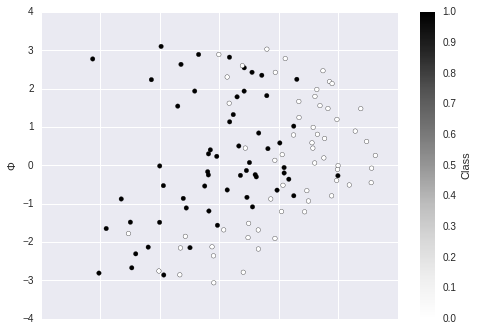

In [6]:
data.plot(kind='scatter', x='R', y='Φ', c='Class')

In [7]:
data.head()

,X,Y,Class,R,Φ
86,-0.755180,0.290200,0,0.809020,-1.203915
85,-0.697580,0.041667,0,0.698823,-1.511136
94,-0.104260,0.991960,0,0.997424,-0.104721
8,0.016705,-0.404240,1,0.404585,3.100292
89,-0.380760,0.918860,0,0.994627,-0.392844


In [8]:
data.describe()

,X,Y,Class,R,Φ
count,118.000000,118.000000,118.000000,118.000000,118.000000
mean,0.054779,0.183102,0.491525,0.706937,0.111792
std,0.496654,0.519743,0.502060,0.222723,1.631429
min,-0.830070,-0.769740,0.000000,0.174684,-3.061275
25%,-0.372120,-0.254385,0.000000,0.564194,-1.043877
50%,-0.006336,0.213455,0.000000,0.710924,-0.011093
75%,0.478970,0.646562,1.000000,0.882128,1.480940
max,1.070900,1.108900,1.000000,1.124362,3.100292


In [9]:
data.Class.value_counts()

0    60
1    58
Name: Class, dtype: int64

## Часть 2. Классификатор kNN

In [10]:
def euclidean_metric(x, y):
    return np.linalg.norm(x - y, 2)

def manhattan_metric(x, y):
    return np.linalg.norm(x - y, 1)

class KNNClassifier(BaseEstimator):
    def __init__(self, k=1, metric=euclidean_metric):
        self.k = k
        self.metric = metric

    def get_params(self, deep=False):
        return {"k": self.k,
                "metric": self.metric}

    def set_params(self, **params):
        self.k = params["k"]
        self.metric = params["metric"]
    
    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X):
        ys = []
        for x in X:
            order = np.apply_along_axis(lambda y: self.metric(x, y), 1, self.X)
            index = np.argsort(order)
            self.y = self.y[index]
            ws = Counter()
            for ix, v in enumerate(self.y[:self.k]):
                # linearly decreasing weights
                w = self.k - ix
                ws[v] = ws.get(v, 0) + w
            ys.append(ws.most_common(1)[0][0])
        return np.asarray(ys)

## Часть 3. Классификатор SVM

In [11]:
class SVMClassifier(BaseEstimator):
    w = None
    w0 = None

    def __init__(self, C=1.0):
        self.C = C

    def get_params(self, deep=False):
        return {"C": self.C}

    def set_params(self, **params):
        self.C = params["C"]

    def fit(self, X, y):
        N = len(X)
        y_Voron = np.apply_along_axis(lambda t: 2 * t - 1, 0, y)

        construct_H = lambda i, j: np.dot(X[i], X[j]) * y_Voron[i] * y_Voron[j]
        H = np.fromfunction(np.vectorize(construct_H), (N, N), dtype=int)
        c = -np.ones(N)
        x0 = np.random.randn(N)
        cons = [ {"type": "ineq", "fun": lambda x: self.C * np.ones(N) - x, "jac": lambda x: -np.eye(N)}
               , {"type": "ineq", "fun": lambda x: x,                       "jac": lambda x:  np.eye(N)}
               , {"type": "eq",   "fun": lambda x: np.dot(y_Voron, x),      "jac": lambda x: y_Voron} ]
        opt = {"disp": False}

        # solve constrained minimization problem using quadratic programming solver
        loss = lambda x: 0.5 * np.dot(x.T, np.dot(H, x)) + np.dot(c, x)
        jac = lambda x: np.dot(x.T, H) + c
        res = sp.optimize.minimize(loss, x0, jac=jac, constraints=cons, method="SLSQP", options=opt)

        # find w, w0
        self.w = np.dot(res.x * y_Voron, X)
        for i, w_i in enumerate(res.x):
            if w_i > 0:
                self.w0 = np.dot(self.w, X[i]) - y_Voron[i]
                break

    def predict(self, X):
        y_pred_Voron = np.sign(np.dot(X, self.w) - self.w0)
        return 0.5 * y_pred_Voron + 0.5

---

## Часть 4. Результаты

### Сравним kNN, SVM и SVC (реализация sk-learn)

In [12]:
%%time

np.random.seed(42)

K = 3
C = 1
cv_score_1 = cross_val_score(KNNClassifier(K), X, y, scoring="f1", cv=20)
cv_score_2 = cross_val_score(SVMClassifier(C), X, y, scoring="f1", cv=20)
cv_score_3 = cross_val_score(SVC(C, kernel="linear"), X, y, scoring="f1", cv=20)

/nix/store/h287x5djidqanlak2fpmz8a87jfdnccg-python3.5-scikit-learn-0.17.1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


CPU times: user 8.03 s, sys: 16 ms, total: 8.05 s
Wall time: 5.09 s


### Параметрический тест Уилкоксона, средний cross_val_score, доверительные интервалы

In [13]:
print("KNN mean score: %.3f" % cv_score_1.mean())
print("SVMClassifier() mean score: %.3f" % cv_score_2.mean())
print("sk-learn SVC() mean score: %.3f" % cv_score_3.mean())

KNN mean score: 0.468
SVMClassifier() mean score: 0.696
sk-learn SVC() mean score: 0.734


In [14]:
print(sp.stats.wilcoxon(cv_score_1, cv_score_2))
print("Confidence interval: [%.3f; %.3f]" % zconfint(cv_score_1, cv_score_2))

WilcoxonResult(statistic=13.0, pvalue=0.0075495977241239638)
Confidence interval: [-0.397; -0.058]


In [15]:
print(sp.stats.wilcoxon(cv_score_2, cv_score_3))
print("Confidence interval: [%.3f; %.3f]" % zconfint(cv_score_2, cv_score_3))

WilcoxonResult(statistic=52.0, pvalue=0.407809041855696)
Confidence interval: [-0.199; 0.123]


### Confusion matrix

In [16]:
np.random.seed(42)

clf = SVMClassifier()
clf.fit(X, y)
y_pred = clf.predict(X)
confusion_matrix(y, y_pred)

array([[50, 10],
       [22, 36]])

**Источники:**

- *К. В. Воронцов, «Математические методы обучения по прецедентам», глава «Линейные методы классификации» (http://machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)*

- *Конспект курса «Построение выводов по данным» от МФТИ и Яндекса, модуль «Непараметрические критерии», раздел 6.3.1 (https://www.dropbox.com/s/97s9zmhu3p2cnfx/Non-parametric%20criteria.pdf)*